In [2]:
#this code paper trades Bitcoin via the Kraken API. In this block of code, the Q matrix is calculated from current data. Because this is live trading,
#The Q matrix is calculated as quickly as the Kraken API allows to recieve data/ your wifi speed. The Q matrix is then stored for the trading strategy 
#it can be put into a function and all values of interest can be returned. However! You'll want to store everything to see the result at it progresses.
#To build the Q matrix to trade on takes a lot of time. It could be sped up by having a large amount of trailing historical data to build the Q matrix on.
#The more data you have more more successful the Q matrix will be. 
#By Max Parizot

import dynamic_Q as Q #import the Q function which provides all of the calculations
import numpy as np
from scipy.linalg import expm
from skopt import BayesSearchCV
from skopt.space import Integer
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.signal import convolve
import time
import requests


# Initialize Data as a DataFrame
Data = pd.DataFrame({'t': [], 'S': [], 'I': [], 'MOBid':[], 'MOAsk': []})
inhomogeneity_convergence = []
Qt_old = np.array([])
#initialize parameters
n=5
N=20
counter = 0
tolerance = 0.001 #Convergence Tolerance

print('starting while loop')
while True:
    start_time = time.time()
    ask_prices, ask_volumes, ask_timestamps, bid_prices, bid_volumes, bid_timestamps, mid_price,ImbalanceRatio = Q.get_LOB(requests.get('https://api.kraken.com/0/public/Depth?pair=XBTUSD'))
    #print('got data', counter)
    
    # Create a new row
    new_row = {'t': bid_timestamps[0], 'S': mid_price, 'I': ImbalanceRatio, 'MOBid':bid_prices[0], 'MOAsk': ask_prices[0]}
    # Append the new row to the DataFrame
    Data=pd.concat([Data, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    # Increment the counter
    counter += 1

    # Every 25 iterations (every 5 seconds), run the Q function
    if counter % 25 == 0:
        print('running Q', counter)
        Qt= Q.make_Q(Data, n, N)
        if Qt_old.shape == Qt.shape and not np.isnan(Qt).any():
            Q_diff=Qt_old - Qt
            Inhomogeneity= np.sum ((Qt_old > 0.5) & (Qt < 0.5) | (Qt_old < 0.5) & (Qt > 0.5)) #trading inefficiencies, which result from indices (market states) where one matrix gives a trading cue (probability value > 0.5) and the other does not.
            inhomogeneity_convergence.append(Inhomogeneity) #store data for future plotting
            print("Qt no longer has NaN values.",Inhomogeneity, 'inefficiencies')
            if np.max(np.abs(Q_diff)) < tolerance:
                print("Qt has converged in {} values.".format(counter))
                break
        else:
            print('Qt_old',Qt_old.shape,'and Qt', Qt.shape, 'have NaN values. Qt_old is now Qt.')
        Qt_old = Qt
    
    end_time = time.time()
    if end_time - start_time <.33 :
        print('sleeping. You have fast wifi! Waiting for', .33 - (end_time - start_time))
        time.sleep(.33 - (end_time - start_time))
    


starting while loop
running Q 25
Qt_old (0,) and Qt (15, 15) have NaN values. Qt_old is now Qt.


c:\Users\Maxparizot\anaconda3\Lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
c:\Users\Maxparizot\Documents\GitHub\TradeonQ\Code_4\dynamic_Q.py:86: RuntimeWarning: divide by zero encountered in divide
  v = np.sum(G, axis=1)
c:\Users\Maxparizot\Documents\GitHub\TradeonQ\Code_4\dynamic_Q.py:86: RuntimeWarning: invalid value encountered in divide
  v = np.sum(G, axis=1)


running Q 50
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 75
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 100
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 125
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 150
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 175
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 200
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 225
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 250
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 275
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 300
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 325
Qt_old (15, 15) and Qt (15, 15) have NaN values. Qt_old is now Qt.
running Q 350
Qt_old (15, 15) 

KeyboardInterrupt: 

In [16]:
#trade on Q code block 
#this code block is the trading strategy. It uses the Q matrix to make trades.
#The trading strategy is simple. If the Q matrix predicts a price increase, buy. If the Q matrix predicts a price decrease, sell.
import dynamic_Q as Q
import requests
import numpy as np
from scipy.linalg import expm
from skopt import BayesSearchCV
from skopt.space import Integer
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.signal import convolve
import time
import matplotlib.pyplot as plt

#Data is the validation data
#Q is the trading matrix
#n is the number of bins
#N is the number of ticks
#cash is the amount of cash to start with
#prob_limit is the probability limit for trading between 0 and 1

# Obtain states and corresponding indices using the getStates function
n = 5 # Number of bins for the imbalance ratio
N = 20 # Number of ticks for the price change
size_of_trade = 1/10000 # Size of trade in terms of fraction of total volume
# Initialize trading variables
start_counter=counter
#initialize parameters
counter = 0 # restart Counter for the trading loop
assets = 0   # Number of assets (stocks) held initially
cash=500 # Starting cash
prob_limit = 0.0 # Probability threshold for trading default is .5
# Active trading loop
Qt= Q.make_Q(Data, n, N)
CASH = []
ASSETS = []
POSITIONS = []
    # Loop through each time point for active trading
print('starting trading size of', size_of_trade*mid_price, 'dollars')
print('you are capable of trading', cash / (size_of_trade*mid_price), 'amount of assets')

while counter < 20500:
    start_time = time.time()
    ask_prices, ask_volumes, ask_timestamps, bid_prices, bid_volumes, bid_timestamps, mid_price,ImbalanceRatio = Q.get_LOB(requests.get('https://api.kraken.com/0/public/Depth?pair=XBTUSD'))
    # Create a new row
    new_row = {'t': bid_timestamps[0], 'S': mid_price, 'I': ImbalanceRatio, 'MOBid':bid_prices[0], 'MOAsk': ask_prices[0]}
    # Append the new row to the DataFrame
    Data=pd.concat([Data, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    Qt= Q.make_Q(Data, n, N)
    # Get the current state
    [rho, DS] = Q.get_states(Data[-N-1:], n, N) # Get the current state

    # Increment the counter
    counter += 1
    # Get row and column indices for the current state in the Q matrix
    row = int(rho + n * (DS + 1) -1)
    downColumn = int(rho -1)
    upColumn = int(rho + 2 * n  -1)

    # If predicting a downward price move
    if Qt[row, downColumn] > .5:
        if assets>=size_of_trade:
            cash = cash + size_of_trade*bid_prices[0] # Sell
            assets = assets - size_of_trade #decrease number of assets
        elif (-assets+size_of_trade)*ask_prices[0] < cash + (assets-size_of_trade) *ask_prices[0]:
            cash = cash + size_of_trade* bid_prices[0]
            assets = assets - size_of_trade
        else:
            print('Sell order halted. Not enough cash to short')

    # If predicting an upward price move
    elif Qt[row, upColumn] > .5:
        if cash>ask_prices[0]:
            cash = cash - size_of_trade*ask_prices[0] # Buy
            assets = assets + size_of_trade # Increase number of assets
    else:
        print('No trade','sell order percentage', Qt[row, downColumn],'buy order percentage', Qt[row, upColumn], 'row',row, 'downColumn',downColumn, 'upColumn', upColumn)
    
    CASH.append(cash)
    ASSETS.append(assets)
    POSITIONS.append(cash+assets*ask_prices[0])
    print('cash', cash, 'assets', assets, 'position', cash+assets*bid_prices[0], 'counter', counter)


# End of trading: liquidate position
if assets > 0:
    cash = cash + assets * bid_prices[0] # Sell off remaining assets
elif assets < 0:
    cash = cash + assets * ask_prices[0] # Buy back remaining short positions
    
CASH.append(cash)
ASSETS.append(assets)
POSITIONS.append(cash+assets*bid_prices[0])


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


starting trading size of 4.276155 dollars
you are capable of trading 116.9274733960766 amount of assets
No trade sell order percentage 0.04264905115425954 buy order percentage 0.347789077696502 row 9 downColumn 4 upColumn 14
cash 500 assets 0 position 500.0 counter 1
No trade sell order percentage 0.042642570208005916 buy order percentage 0.3477368338015689 row 9 downColumn 4 upColumn 14
cash 500 assets 0 position 500.0 counter 2
No trade sell order percentage 0.04263609104139499 buy order percentage 0.3476846039134893 row 9 downColumn 4 upColumn 14
cash 500 assets 0 position 500.0 counter 3
No trade sell order percentage 0.04262961365378937 buy order percentage 0.3476323880274982 row 9 downColumn 4 upColumn 14
cash 500 assets 0 position 500.0 counter 4
No trade sell order percentage 0.046929952932643175 buy order percentage 0.37735896166924987 row 14 downColumn 4 upColumn 14
cash 500 assets 0 position 500.0 counter 5
No trade sell order percentage 0.04692388510355963 buy order percent

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [6]:
#This section of code is used to debug the Q matrix and the states. It is not necessary for trading.
rho, DS= Q.get_states((Data[-N-1:]), n, N)
print('rho', rho)
print('DS', DS)

rho [1]
DS [0.]


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Qt has developed 42 inefficiencies in 20500 iterations


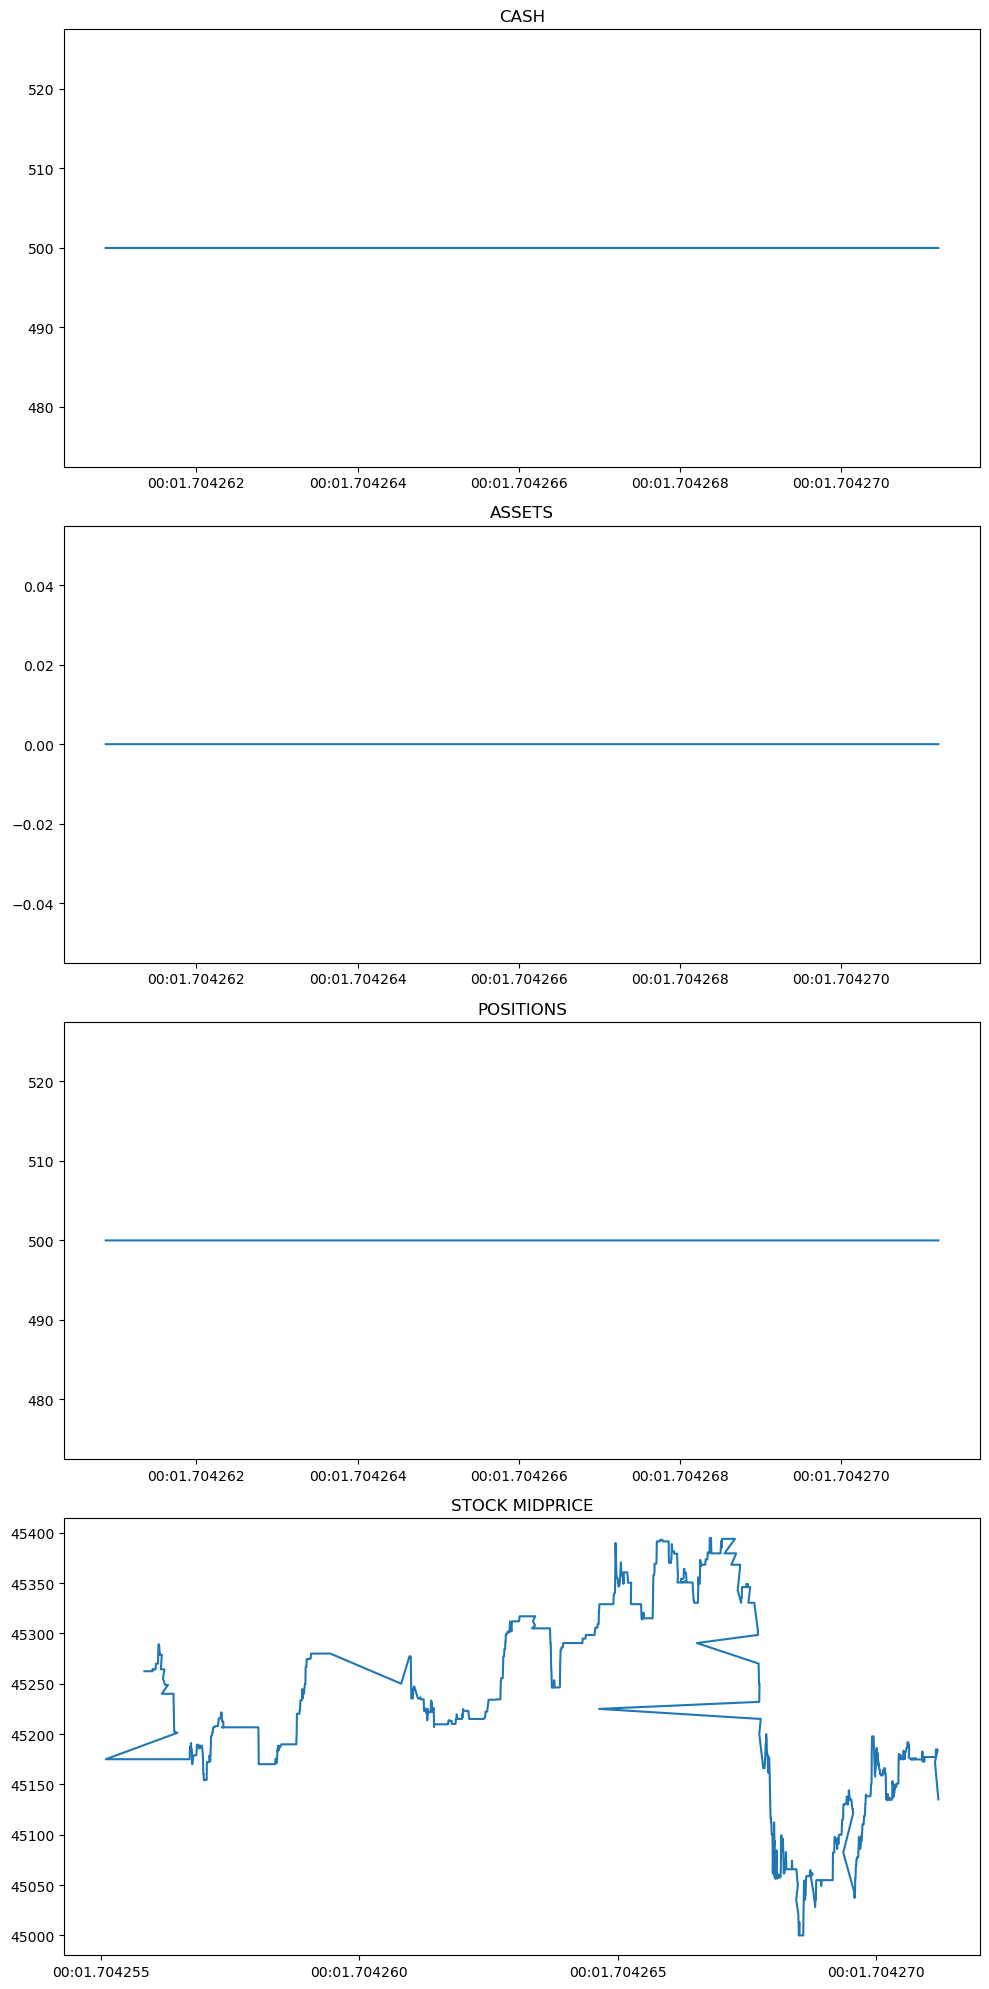

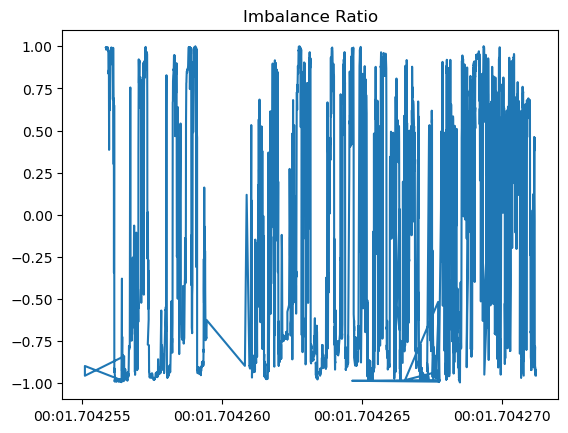

In [11]:
#This section of code is used to analyze the results of the trading strategy. It is not necessary for trading but provides a good visualization of the results.
#analyze results
Qt_new= Q.make_Q(Data, n, N)
Dt_diff=Qt_new - Qt
Inhomogeneity= np.sum ((Qt_new > 0.5) & (Qt < 0.5) | (Qt_new < 0.5) & (Qt > 0.5)) #trading inefficiencies, which result from indices (market states) where one matrix gives a trading cue (probability value > 0.5) and the other does not.
print('Qt has developed', Inhomogeneity, 'inefficiencies in', counter, 'iterations')
# Plot the results
# Convert 't' column to datetime for better visualization
Data['t'] = pd.to_datetime(Data['t'])

# Set the style of the plot
plt.style.use('seaborn-darkgrid')

# Create a new figure
plt.figure(figsize=(10,20))

# Plot CASH
plt.subplot(411)
plt.plot(Data['t'].iloc[-len(CASH):], CASH, color='blue', linestyle='-')
plt.title('CASH', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Cash', fontsize=12)

# Plot ASSETS
plt.subplot(412)
plt.plot(Data['t'].iloc[-len(ASSETS):], ASSETS, color='green', linestyle='-')
plt.title('ASSETS', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Assets', fontsize=12)

# Plot POSITIONS
plt.subplot(413)
plt.plot(Data['t'].iloc[-len(POSITIONS):], POSITIONS, color='red', linestyle='-')
plt.title('POSITIONS', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Positions', fontsize=12)

# Plot Data['S']
plt.subplot(414)
plt.plot(Data['t'], Data['S'], color='purple', linestyle='-')
plt.title('STOCK MIDPRICE', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Midprice', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Create a new figure
plt.figure(figsize=(10,10))
# Plot Imbalance Ratio
plt.plot(Data['t'], Data['I'], color='orange', linestyle='-')
plt.title('Imbalance Ratio', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Imbalance Ratio', fontsize=12)
# Show the plot
plt.show()